In [155]:
import pandas as pd
import numpy as np
import torch
from torch import nn

In [156]:
data = pd.read_csv('data/BTCUSDT_1DAY_data.csv')
data

,Timestamp,Open,High,Low,Close,Volume
0,2023-01-01,16541.77,16628.00,16499.01,16616.75,96925.41374
1,2023-01-02,16617.17,16799.23,16548.70,16672.87,121888.57191
2,2023-01-03,16672.78,16778.40,16605.28,16675.18,159541.53733
3,2023-01-04,16675.65,16991.87,16652.66,16850.36,220362.18862
4,2023-01-05,16850.36,16879.82,16753.00,16831.85,163473.56641
...,...,...,...,...,...,...
270,2023-09-28,26373.00,27308.48,26342.40,27021.39,44517.83491
271,2023-09-29,27021.39,27244.89,26665.16,26906.96,28478.76219
272,2023-09-30,26906.96,27094.99,26886.31,26962.56,12804.62307
273,2023-10-01,26962.57,28065.51,26954.09,27992.57,24602.81468


In [157]:
# data = {
#     'Timestamp':list(range(1, 11)),
#      'Open':list(range(1, 11)),
#      'High':list(range(1, 11)),
#      'Low':list(range(1, 11)),
#      'Close':list(range(1, 11)),
#      'Volume':list(range(1, 11)),
# }
# data = pd.DataFrame(data)
# data

In [158]:
import environment
from environment import TradingEnvironment
import importlib
importlib.reload(environment)

env = TradingEnvironment(data=data,
                         initial_balance=500000,
                         transaction_fee=10)

In [159]:
# np.random.seed(42)

balances = []
portfolios = []
actions = []
for i in range(len(data)):
    # if i == 1:
    #     action = -1
    # else:
    #     action = 0
    print(i)

    action = np.random.choice([-1, 0, 0, 0, 0, 0, 0, 0, 1])
    volume = np.random.choice(range(6))+1
    # volume = 20

    game_over, balance = env.step(action, volume)

    balances.append(balance)
    portfolios.append(env.portfolio_value)
    actions.append(action)
    print()
    if game_over:
        break

0
Holding position.

1
Opened new SHORT position:
Volume: 5
Purchase Price: 16617.17
Cost: 83085.84999999999

2
Holding position.

3
Holding position.

4
Holding position.

5
Holding position.

6
Holding position.

7
Holding position.

8
Holding position.

9
Bought more SHORT position:
Additional Volume: 3
Updated Purchase Price: 16827.87125
Cost: 51537.12

10
Holding position.

11
Sold 8 shares of SHORT position for 17943.26.
Total Transaction Profit: -2230.7774999999965

12
Holding position.

13
Holding position.

14
Holding position.

15
Holding position.

16
Holding position.

17
Holding position.

18
Holding position.

19
Holding position.

20
Holding position.

21
Holding position.

22
Holding position.

23
Holding position.

24
Holding position.

25
Sold 6 shares of SHORT position for 23060.42.
Total Transaction Profit: -37395.29249999998
Position closed

26
Holding position.

27
Holding position.

28
Holding position.

29
Holding position.

30
Holding position.

31
Opened new S

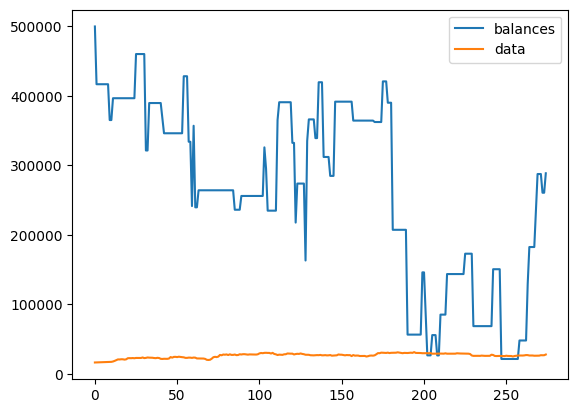

In [160]:
import matplotlib.pyplot as plt

plt.plot(balances, label='balances')
plt.plot(data['Open'], label='data')
# plt.plot(portfolios, label='portfolios')
plt.legend()
plt.show()

In [113]:
portfolios

[0, 40, 20, 0, -20, -40, 0]

In [114]:
balances

[100, 50, 50, 50, 50, 50, -20]